In [554]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import datetime as dt
import requests
import os
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

## Scraping

In [486]:
# url filters: jobs posted within past day, within 15 miles of New York, NY
google_jobs_url = 'https://www.google.com/search?q=jobs&oq=google+jobs+data+analyst&aqs=chrome..69i57j69i59j0i512j0i22i30i625l4j69i60.4543j0j7&sourceid=chrome&ie=UTF-8&ibp=htl;jobs&sa=X&ved=2ahUKEwjXsv-_iZP9AhVPRmwGHX5xDEsQutcGKAF6BAgPEAU&sxsrf=AJOqlzWGHNISzgpAUCZBmQA1mWXXt3I7gA:1676311105893#fpstate=tldetail&htivrt=jobs&htichips=city:Owg_06VPwoli_nfhBo8LyA%3D%3D,date_posted:today&htischips=city;Owg_06VPwoli_nfhBo8LyA%3D%3D:New%20York_comma_%20NY,date_posted;today&htilrad=24.1401&htidocid=9dwQD_uVzp1Nu-9BAAAAAA%3D%3D'
# path to CSV where google jobs dataset will be held
descr_df_path = '/Users/ravram/Desktop/pay-transparency/data/output/google-jobs-cronjob.csv' # need to change path when put on server
# path to CSV where extra column data will be held
scroll_df_path = '/Users/ravram/Desktop/pay-transparency/data/output/google-jobs-extra-cols-cronjob.csv' # need to change path when put on server

In [534]:
# function that scrapes data from Google Jobs

def scrape_google_jobs(url, scroll_path_location, descr_path_location, postings):
    
# url: web url to the google jobs page that will be scraped (str)
# scroll_path_location: path to the CSV file where the data scraped from the scroll section of Google Jobs will be stored (str)
# descr_path_location: path to the CSV file where the data scraped from the job description section of Google Jobs will be stored (str)
# postings: number of job postings to be scraped -> can be increased by increments of 10 starting at 20, going up to limit of 150 (int)
    
    options = Options() # preparing to run in headless browser
    options.add_argument('headless') 

    # using sing selenium to launch and scroll through the Google Jobs page
    url = url
    driver = webdriver.Chrome(options=options)
    
    user_agent = driver.execute_script("return navigator.userAgent;")
    user_agent = user_agent.replace("HeadlessChrome","Chrome")
    driver.execute_cdp_cmd('Network.setUserAgentOverride',{"userAgent": f'{user_agent}'})
    
    driver.get(url)
    
    # column names and paths to desired data on scroll section of website
    xpaths_scr = {
         'Role'            :"./div[2]",
         'Company'         :"./div[4]/div/div[1]",
         'Source'          :"./div[4]/div/div[3]",
         'Full / Part Time':".//*[name()='path'][contains(@d,'M20 6')]/ancestor::div[1]",
        }
    
    scrolls_to_do = postings # setting number of job postings to be scraped
    scrolls_done = 0
    data_scr = {key:[] for key in xpaths_scr} # data will be added to this dict
    
    # stay in while loop until desired number of postings have been scrolled to
    while scrolls_done < scrolls_to_do: 
        lis_scr = driver.find_elements(By.XPATH, "//li[@data-ved]//div[@role='treeitem']/div/div") # path to section of page where user can scroll through job postings 

        if (len(lis_scr) == scrolls_done) and (scrolls_to_do - scrolls_done) > 0: # in case the postings variable exceeds number of available job posting entries (otherwise code will be stuck in infinite loop)
        
            # print('\nNote: requested # of postings greater than available postings')
            scrolls_to_do = len(lis_scr) # resetting scrolls_to_do to the max length of lis_scr so can break out of while loop
            
        # scrolling down the page to make desired number of job postings load, therefore making them accessible for scraping
        for li_scr in lis_scr[scrolls_done:]:
            driver.execute_script('arguments[0].scrollIntoView({block: "center", behavior: "smooth"});', li_scr) 

            for key in xpaths_scr:
                try: # pull data at each path in the xpaths dict for each job posting
                    t = li_scr.find_element(By.XPATH, xpaths_scr[key]).get_attribute('innerText')
                except NoSuchElementException: # if can't find, indicate with text
                    t = '*missing data*'
                    
                data_scr[key].append(t) # add to data dict
            
            scrolls_done += 1
            print(f'{scrolls_done=}', end='\r') # to visualize how many scrolls have been performed
            time.sleep(.2)    
            
    scr_scraped_df = pd.DataFrame(data_scr) # convert to df
    
    print('')
    
    ####
    
    # column names and paths to desired data in job description page section of website
    xpaths_descr = { 
         'Role'            :"./div/div[1]/div/div[1]/h2",
         'Company'         :"./div/div[1]/div/div[2]/div[2]/div[1]",
         'Location'        :"./div/div[1]/div/div[2]/div[2]/div[2]",
         'Posted'          :"./div/div[3]/div[1]/span[2]/span",
         'Scraped Salary'  :".//span[@class='LL4CDc' and contains(@aria-label,'Salary')]/span",
         'Job Highlights'  :"./div/div[4]/div[1]/div[2]/g-expandable-container/div/g-expandable-content[2]/span",
         'Job Description' :"./div/div[5]/div/span",
         'Any Other Text'  :"./div/div[4]" 
        }
    
    descr_done = 0
    data_descr = {key:[] for key in xpaths_descr} # data will be added to this dict
    data_descr['Date Scraped'] = []
    
    lis_descr = driver.find_elements(By.XPATH, "//*[@id='gws-plugins-horizon-jobs__job_details_page']") # path to description page for each job 
    
    for li_descr in lis_descr[0:scrolls_to_do]: # looping through desired number of job description pages
    
        for key in xpaths_descr:

            try: # pull data at each path in the xpaths dict for each job posting
                t = li_descr.find_element(By.XPATH, xpaths_descr[key]).get_attribute('innerText')
            except NoSuchElementException: # if can't find, indicate with text
                t = '*missing data*'
            if t == '': # in cases where element exists but is just ''
                t='*missing data*'
                
            data_descr[key].append(t) # add to data dict
            
        data_descr['Date Scraped'].append(dt.datetime.now()) # adding date scraped
            
        descr_done += 1
        print(f'{descr_done=}', end='\r') # to visualize how many description pages have been scraped
        time.sleep(.2)
        
    descr_scraped_df = pd.DataFrame(data_descr) # convert to df
    
    for ind in descr_scraped_df.index: # Any Other Text collects full text for posting... only worth keeping if Job Highlights and Description are both empty, otherwise redundant info just taking up space
        
        if (descr_scraped_df['Job Highlights'][ind] != '*missing data*') or (descr_scraped_df['Job Description'][ind] != '*missing data*'):
            
            descr_scraped_df.loc[ind, 'Any Other Text'] = np.nan # erasing this text if either Job Highlights or Job Description is present
    
    scr_path = scroll_path_location 
    
    if os.path.exists(scr_path): # if CSV already exists at the specified path, add the new data found in scr_scraped_df
        scr_original_df = pd.read_csv(scr_path) # convert existing CSV to df
        scr_original_df = pd.concat([scr_original_df,scr_scraped_df]) # add new data
        scr_original_df = scr_original_df.drop_duplicates() # drop entries with identical data 
        scr_original_df.to_csv(scr_path, index = False) # redownloading updated df to the specified path
    else: # otherwise, create new file at this path (for first time function is run)
        scr_scraped_df.to_csv(scr_path, index = False) 
        
    descr_path = descr_path_location 
    
    if os.path.exists(descr_path): # if CSV already exists at the specified path, add the new data found in descr_scraped_df 
        descr_original_df = pd.read_csv(descr_path) # convert existing CSV to df
        descr_original_df = pd.concat([descr_original_df,descr_scraped_df]) # add new data
        descr_original_df = descr_original_df.drop_duplicates(subset=['Role','Company','Location','Scraped Salary','Job Highlights','Job Description', 'Any Other Text']) # drop entries with identical data in these columns... leaving Posted out of this in case duplicates are posted at dif times
        descr_original_df.to_csv(descr_path, index = False) # redownloading updated df to the specified path
    else: # otherwise, create new file at this path (for first time function is run)
        descr_scraped_df.to_csv(descr_path, index = False)  
    
    return

In [535]:
scrape_google_jobs(google_jobs_url, scroll_df_path, descr_df_path, 150)

scrolls_done=158


## Data Cleaning

In [573]:
# function that adds columns from google_jobs_scr_df to google_jobs_descr_df based on unique job keys
# to be run after final dataset is compiled

def add_columns(google_jobs_descr_df, google_jobs_scr_df):
    
# google_jobs_descr_df: df containing all of the data from the job description page scrape (DataFrame)
# google_jobs_scr_df: df containing the columns from the Google Jobs scroll section to be added to google_jobs_descr_df (DataFrame)

    # initializing empty dicts
    source_dict = {}
    time_dict = {}
    
    for ind in google_jobs_scr_df.index: 
    
        col_key = google_jobs_scr_df['Role'][ind] + google_jobs_scr_df['Company'][ind] # create unique job key (title and company combined)
        
        source_dict[col_key] = google_jobs_scr_df['Source'][ind] # add Source data as value associated with job key
        time_dict[col_key] = google_jobs_scr_df['Full / Part Time'][ind] # add Full / Part Time data as value as value associated with job key
    
    # initializing columns in google_jobs_descr_df
    google_jobs_descr_df['Key'] = ''
    google_jobs_descr_df.insert(4, 'Source', '')
    google_jobs_descr_df.insert(5, 'Full / Part Time', '')
    
    for ind in google_jobs_descr_df.index:
        
        df_key = google_jobs_descr_df['Role'][ind] + google_jobs_descr_df['Company'][ind] # create unique job key to be matched with key in source_dict/time_dict
        google_jobs_descr_df['Key'][ind] = df_key
        
    for ind in google_jobs_descr_df.index:
    
        for col_key in source_dict.keys(): # matching keys between df and dicts

            if google_jobs_descr_df['Key'][ind] == col_key: 

                # adding values associated with key
                google_jobs_descr_df['Source'][ind] = source_dict[col_key] 
                google_jobs_descr_df['Full / Part Time'][ind] = time_dict[col_key]
            
    google_jobs_df = google_jobs_descr_df.drop(columns=['Key'])
    
    return google_jobs_df # updated df with new columns added

In [574]:
# function that cleans salary lists that would otherwise be labeled as ambiguous due to having over two entries
# specifically, removes duplicates from lists so that they won't be flagged as having over 2 entries
# called in pull_and_process_salaries()

def clean_salary_ambiguous(row):
    
# row: value in the 'Salary From Text' column at a given index of the df -> will be fed in as df['Salary From Text'][ind] (str)
    
    #k_list = [i for i in list(range(len(lst))) if 'k' in lst[i].lower()]
    
    # since letters are about to be removed below, need to note when a number is really meant to be multiplied by 1000
    if 'k' in ''.join(row).lower():
        magnitude = 'k'
    else:
        magnitude = ''
        
    ambig_lst = []
        
    for i in row:
        
        num = re.sub(r'[^0-9.]', '', i)
        
        splited = num.split('.') # in case there's more than one period remaining (eg '$16.00/hr.' -> '16.00.')
        num=".".join(splited[0:2])
        num+="".join(splited[2:])
            
        ambig_lst.append(num)
        
        if '' in ambig_lst: ambig_lst.remove('')
        ambig_lst = [round(float(x),1) for x in ambig_lst]    

        lst_drop_dups = []

        [lst_drop_dups.append(x) for x in ambig_lst if x not in lst_drop_dups]
        
        row = [(str(x) + magnitude) for x in lst_drop_dups] # need to convert back to str in order for the find_salaries() to properly process
            
    return row
            

In [638]:
# function that pulls potential salaries from specified column containing job description text at specified index
# ouputs list of potential salaries
# called by pull_and_process_salaries()

def find_salaries(df, col_name, ind):
    
# df: df containing all of the compiled google jobs data (DataFrame)
# col_name: name of column containing job description text (str)
# ind: index of df[col_name] that is being searched for salaries (int)
    
    salary_list = [] # initializing empty list for this job entry

    phrase = df[col_name][ind] # text in description
    phrase = phrase.replace('•',' ') # eliminating bullet points
    phrase_to_list = phrase.split(" ") # creating list of all strings in the description

    for i in range(len(phrase_to_list)): # iterating through phrase_to_list

        if len(phrase_to_list[i]) > 0: # otherwise -1 index will break code

            if phrase_to_list[i] not in ['401K', '401k']: # eliminating '401K' so doesn't get labeled as salary

                if not [True if e in phrase_to_list[i].lower() else False for e in ['b','m']][0]: # weeding out cases like '$10b industry' or '$3M company'
                    
                    # looking for salary indicators (using '$' and 'K')
                    
                    if ('$' in phrase_to_list[i]) or ((len(phrase_to_list[i]) > 1) and ('k' == phrase_to_list[i][-1].lower()) and (phrase_to_list[i][-2].isdigit())): 
                        
                        salary_list.append(phrase_to_list[i]) # adding strings with salary indicators to ongoing list

                    if phrase_to_list[i] == '$' and phrase_to_list[i+1][0].isdigit(): # if there's a space between $ and number

                        salary_list.append(phrase_to_list[i+1]) # add the subsequent list item in this case

                    # df['Salary From Text'][ind] = salary_list # place in this new column
                        
    return salary_list   

In [639]:
# function that pulls salaries from the job description text using find_salaries()
# then determines lower and upper bounds (if they exist) using data from either Scraped Salary or Salary From Text, placing them in their own columns 
# if no salaries found, or salaries cannot be determined from the collected data, will flag with text indicators

def pull_and_process_salaries(df): 

# df: df containing all of the compiled google jobs data (DataFrame)
    
    df['Salary From Text'] = '' # creating column where salaries found in description will be placed
    df['Salary Lower Bound'] = '' # lower bound
    df['Salary Upper Bound'] = '' # upper bound
    
    # pulling salaries from the different text boxes
    
    for ind in df.index: # first round iterating through df
        
        if df['Any Other Text'][ind] is not np.nan: # if no Job Highlights or Job Description scraped, look at Any Other Text to find salary
            
             df['Salary From Text'][ind] = find_salaries(df, 'Any Other Text', ind)
            
        else: # otherwise pull from Job Highlights
            
            df['Salary From Text'][ind] = find_salaries(df, 'Job Highlights', ind)
        
            if df['Salary From Text'][ind] == []: # if salary was not found in Job Highlights, look for salary in Job Description
                
                df['Salary From Text'][ind] = find_salaries(df, 'Job Description', ind)

    # now that salaries are pulled from the description text, will create lower and upper bounds based on given info
    
    for ind in df.index:
    
        if df['Scraped Salary'][ind] == '*missing data*': # if salary not initially scraped

            if df['Salary From Text'][ind] == []: # if no salary found in any of the description texts

                df['Salary Lower Bound'][ind] = '*no salary found*'
                df['Salary Upper Bound'][ind] = '*no salary found*'

            else: # if salary is found anywhere on the description page

                # if first value is just $, remove so doesn't affect making the range (cases where there's originally a space between $ and number)

                for i in df['Salary From Text'][ind]:
                    if i == '$':
                        df['Salary From Text'][ind].remove('$') 

                desc_sal_list = [] # in cases where there are two "numbers" that are really 1-2 ranges -> [20K-30K,5K-6K] or [20K,15K-16K]

                for i in range(len(df['Salary From Text'][ind])): # removing the dashes and isolating all of the individual numbers

                    if '–' in df['Salary From Text'][ind][i]: 
                        desc_sal = df['Salary From Text'][ind][i].replace('–', ' ')
                    if '—' in df['Salary From Text'][ind][i]: 
                        desc_sal = df['Salary From Text'][ind][i].replace('—', ' ')
                    elif '-' in df['Salary From Text'][ind][i]:
                        desc_sal = df['Salary From Text'][ind][i].replace('-', ' ')
                    else:
                        desc_sal = df['Salary From Text'][ind][i]

                    desc_sal_list = desc_sal_list + desc_sal.split(' ')

                    if '' in desc_sal_list: desc_sal_list.remove('')

                df['Salary From Text'][ind] = desc_sal_list

                # attempting to preemptively correct cases that would otherwise trigger 'salary ambiguous' label so that they can be properly processed

                if len(df['Salary From Text'][ind]) > 2: # when length of list > 2, will be marked ambiguous unless corrected first

                    df['Salary From Text'][ind] = clean_salary_ambiguous(df['Salary From Text'][ind]) # using clean_salary_ambiguous() function

                # now that all the lists are as cleaned up as possible, proceed to determine salary ranges:

                if len(df['Salary From Text'][ind]) > 2: # if multiple numbers are still found after cleaning, hard to tell what salary range is, will be marked ambiguous

                    df['Salary Lower Bound'][ind] = '*salary ambiguous*'
                    df['Salary Upper Bound'][ind] = '*salary ambiguous*'

                if len(df['Salary From Text'][ind]) == 2: # if two entries provided, create salary range

                    df['Salary Lower Bound'][ind] = df['Salary From Text'][ind][0] 
                    df['Salary Upper Bound'][ind] = df['Salary From Text'][ind][1]

                elif len(df['Salary From Text'][ind]) == 1: # one entry

                    df['Salary Lower Bound'][ind] = df['Salary From Text'][ind][0] 

        else: # if salary found in initial scrape, use it as final salary  

            if '–' in df['Scraped Salary'][ind]: # removing dashes
                scraped_sal = df['Scraped Salary'][ind].replace('–', ' ')
            elif '—' in df['Scraped Salary'][ind]: # removing dashes
                scraped_sal = df['Scraped Salary'][ind].replace('—', ' ')
            elif '-' in df['Scraped Salary'][ind]: # removing dashes
                scraped_sal = df['Scraped Salary'][ind].replace('-', ' ')
            else: # if no dashes present, just leave as is
                scraped_sal = df['Scraped Salary'][ind]

            scraped_sal_list = scraped_sal.split(' ') # seperating into list of strings

            df['Salary Lower Bound'][ind] = scraped_sal_list[0] # first number
            df['Salary Upper Bound'][ind] = scraped_sal_list[1] # second number

    return df

In [640]:
# function that cleans salaries pulled from text in string form, then converts them to numbers
# creates salary ranges and ratios
# flags when no salary range or ratio can be generated due to insufficient/ nonexistent data

def clean_salaries(df):
    
# df: df containing all of the processed google jobs data (DataFrame)
    
    df['Salary Magnitude'] = '' 
    df['Salary Range'] = ''
    df['Salary Ratio'] = ''
    
    for ind in df.index:
        
        lower = df['Salary Lower Bound'][ind]
        upper = df['Salary Upper Bound'][ind]
        
        if df['Salary Lower Bound'][ind] not in ['*no salary found*','*salary ambiguous*']: # only for entries that have values
        
            df['Salary Magnitude'][ind] = [1000 if (('k' in lower.lower()) or ('k' in upper.lower())) else 1][0] # if 'K' in entry, will mutliply by 1000 when converting to number            
            
            # removing all non-numerical characters except for decimals

            lower = re.sub(r'[^0-9.]', '', lower)
            
            splited = lower.split('.') # in case there's more than one period remaining (eg '$16.00/hr.' -> '16.00.')
            lower=".".join(splited[0:2])
            lower+="".join(splited[2:])
            
            df['Salary Lower Bound'][ind] = lower # cleaned lower bound
            
            upper = re.sub(r'[^0-9.]', '', upper)
            
            splited = upper.split('.')
            upper=".".join(splited[0:2])
            upper+="".join(splited[2:])
            
            df['Salary Upper Bound'][ind] = upper # cleaned upper bound
    
            # if this cleaning leaves the entry emtpy, leave this message:
            
            df['Salary Lower Bound'][ind] =  ['*no number present*' if df['Salary Lower Bound'][ind] == '' else df['Salary Lower Bound'][ind]][0] 
            df['Salary Upper Bound'][ind] =  ['*no number present*' if df['Salary Upper Bound'][ind] == '' else df['Salary Upper Bound'][ind]][0] 
            
            # multiplying by 1 or 1000 depending on whether or not 'K' was present in original entry
            
            if df['Salary Lower Bound'][ind] != '*no number present*': # if number found

                df['Salary Lower Bound'][ind] = (float(df['Salary Lower Bound'][ind]) * df['Salary Magnitude'][ind])
            
            if df['Salary Upper Bound'][ind] != '*no number present*':
    
                df['Salary Upper Bound'][ind] = float(df['Salary Upper Bound'][ind]) * df['Salary Magnitude'][ind]
            
            # if there are two numbers, create column with polished range, add ratio to new col
            
            if (df['Salary Lower Bound'][ind] != '*no number present*') and (df['Salary Upper Bound'][ind] != '*no number present*'):
                        
                # in cases where they were placed in wrong order

                if df['Salary Lower Bound'][ind] > df['Salary Upper Bound'][ind]: 
            
                    real_upper = df['Salary Lower Bound'][ind] 
                    real_lower = df['Salary Upper Bound'][ind]

                    df['Salary Lower Bound'][ind] = real_lower # switching which column each is placed in
                    df['Salary Upper Bound'][ind] = real_upper
                
                df['Salary Range'][ind] = '${:,.2f}'.format(df['Salary Lower Bound'][ind]) + '-' + '${:,.2f}'.format(df['Salary Upper Bound'][ind])
                df['Salary Ratio'][ind] = round((df['Salary Upper Bound'][ind] / df['Salary Lower Bound'][ind]),1)
                
            # if just one value, include that value alone, with ratio set to 1
            
            elif (df['Salary Lower Bound'][ind] != '*no number present*') and (df['Salary Upper Bound'][ind] == '*no number present*'):
                
                df['Salary Range'][ind] = '${:,.2f}'.format(df['Salary Lower Bound'][ind])
                df['Salary Ratio'][ind] = 1.0
                
            # if both numbers were removed in cleaning process, treat as if no salary was found
            
            elif (df['Salary Lower Bound'][ind] == '*no number present*') and (df['Salary Upper Bound'][ind] == '*no number present*'):
                
                df['Salary Range'][ind] = '*no salary found*'
                df['Salary Ratio'][ind] = '*no salary found*'
            
        if df['Salary Lower Bound'][ind] == '*no salary found*': # if no salary found
            
            df['Salary Range'][ind] = '*no salary found*'
            df['Salary Ratio'][ind] = '*no salary found*'
                
        if df['Salary Lower Bound'][ind] == '*salary ambiguous*': # if salary cannot be determined

            df['Salary Range'][ind] = '*salary ambiguous*'
            df['Salary Ratio'][ind] = '*salary ambiguous*'
                
    df = df.drop(columns=['Salary Magnitude'])
                   
    return df
    

In [653]:
# function that allows for manual updating of salary lower bound, upper bound, range, and ratio at specific index

def update_salary(df, lower, upper, ind):
    
# df: df containing all of the cleaned google jobs data (DataFrame)
# lower: updated salary lower bound (int)
# upper: updated salary upper bound (int)
# ind: index where updated salary information will be placed 9int
    
    # manually entering lower and upper bounds
    
    df['Salary Lower Bound'][ind] = lower 
    df['Salary Upper Bound'][ind] = upper
    
    # manually updating salary range and ratio
    
    df['Salary Range'][ind] = '${:,.2f}'.format(df['Salary Lower Bound'][ind]) + '-' + '${:,.2f}'.format(df['Salary Upper Bound'][ind])
    df['Salary Ratio'][ind] = round((df['Salary Upper Bound'][ind] / df['Salary Lower Bound'][ind]),1)
    
    return
                

## Taking a Look at the Results

In [641]:
# results from local function

# google_jobs_scr_df = pd.read_csv(scroll_df_path)
# google_jobs_descr_df = pd.read_csv(descr_df_path)

# google_jobs_df = add_columns(google_jobs_descr_df, google_jobs_scr_df) # adding 'Source' and 'Full / Part Time'
#     #google_jobs_df_add_sal = find_salaries(google_jobs_df)
# google_jobs_df_add_sal = pull_and_process_salaries(google_jobs_df)
# google_jobs_df_cleaned = clean_salaries(google_jobs_df_add_sal)
# google_jobs_df_cleaned.loc[90:]

In [642]:
# results from cron job scrape

google_jobs_descr_test = pd.read_csv('/Users/ravram/Desktop/google-jobs-cronjob.csv')
google_jobs_scr_test = pd.read_csv('/Users/ravram/Desktop/google-jobs-extra-cols-cronjob.csv')
google_jobs_test = add_columns(google_jobs_descr_test, google_jobs_scr_test) 
    #google_jobs_df_add_sal_test = find_salaries(google_jobs_test)
google_jobs_df_add_sal_test = pull_and_process_salaries(google_jobs_test)
google_jobs_df_cleaned_test = clean_salaries(google_jobs_df_add_sal_test)
google_jobs_df_cleaned_test.loc[670:]

,Role,Company,Location,Posted,Source,Full / Part Time,Scraped Salary,Job Highlights,Job Description,Any Other Text,Salary From Text,Salary Lower Bound,Salary Upper Bound,Salary Range,Salary Ratio
670,QUALITY CONTROL CASE REVIEWER,City of New York,"New York, NY",22 hours ago,via SmartRecruiters Job Search,Full-time,*missing data*,Qualifications•A baccalaureate degree from an ...,Job Description\n\nThe Office of Quality Assur...,NaN,[],*no salary found*,*no salary found*,*no salary found*,*no salary found*
671,Appliance and Refrigeration Repair Technician,Labor Finders,"New York, NY",23 hours ago,via ZipRecruiter,Full-time,*missing data*,Qualifications•You like solving problems - Eac...,Appliance and Refrigeration Repair Technician ...,NaN,"[18.0, 30.0, 4000.0, 6.0]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*
672,AGENT,World Travel & Connect,Anywhere,13 hours ago,via LinkedIn,Part-time,*missing data*,*missing data*,*missing data*,Estamos buscando un coordinador de viajes diná...,[],*no salary found*,*no salary found*,*no salary found*,*no salary found*
673,Senior Network Engineer,City of New York,"New York, NY",22 hours ago,via SmartRecruiters Job Search,Full-time,*missing data*,Qualifications•A baccalaureate degree from an ...,Job Description\n\nThe salary range for this p...,NaN,"[$75,000, 180,000...\n\nThe]",75000.0,180000.0,"$75,000.00-$180,000.00",2.4
674,Porter,Columbia University,"New York, NY",23 hours ago,via ZipRecruiter,Full-time,*missing data*,Qualifications•High School Diploma and/or the ...,Porter Back Apply Share\n• Requisition no: 534...,NaN,"[$18.58, $20.30]",18.58,20.3,$18.58-$20.30,1.1
675,Laboratory Supervisor - Core Laboratory - Even...,NewYork-Presbyterian Hospital,"New York, NY",9 hours ago,via LinkedIn,Full-time,*missing data*,Qualifications•Minimum of 6 years clinical lab...,"Location\n\nCortlandt Manor, New York...\n\nSh...",NaN,"[Range\n\n$71,500, $159,000/Annual\n\nIt]",71500.0,159000.0,"$71,500.00-$159,000.00",2.2
676,Assistant /Associate Professor of Neurology at...,Columbia University,"New York, NY",7 hours ago,via Snagajob,Full-time and Part-time,*missing data*,Qualifications•All applicants MUST meet these ...,The Epilepsy and Sleep Division at Columbia Un...,NaN,[],*no salary found*,*no salary found*,*no salary found*,*no salary found*
677,"Director, Global Market Development GI-BU",Olympus Corporation of the Americas,"New York, NY",3 hours ago,via LinkedIn,Full-time,*missing data*,Qualifications•Bachelor of Science Degree is r...,"Working Location: MASSACHUSETTS, WESTBOROUGH; ...",NaN,[],*no salary found*,*no salary found*,*no salary found*,*no salary found*
678,"Agency Attorney, L3",City of New York,"New York, NY",22 hours ago,via SmartRecruiters Job Search,Full-time,*missing data*,Qualifications•Admission to the New York State...,"Job Description\n\nUnder direction, with wide ...",NaN,[],*no salary found*,*no salary found*,*no salary found*,*no salary found*
679,Field Energy Engineer (commercial),APTIM,"New York, NY",21 hours ago,via LinkedIn,Full-time,*missing data*,Qualifications•Must be willing to travel an av...,"At APTIM, we come to work each day knowing tha...",NaN,[],*no salary found*,*no salary found*,*no salary found*,*no salary found*


In [652]:
google_jobs_df_cleaned_test.loc[:59]

,Role,Company,Location,Posted,Source,Full / Part Time,Scraped Salary,Job Highlights,Job Description,Any Other Text,Salary From Text,Salary Lower Bound,Salary Upper Bound,Salary Range,Salary Ratio
0,Community Health Worker/Patient Services Coord...,Mount Sinai Health Systems,"New York, NY",20 hours ago,via Careers Mount Sinai,Full-time,*missing data*,Qualifications•Bachelor’s Degree•3 Years Healt...,Description\n\nThe Community Healthcare Worker...,NaN,"[17.0, 31.6]",17.0,31.6,$17.00-$31.60,1.9
1,Video Editor,Industrial Color,"New York, NY",15 hours ago,via LinkedIn,Full-time,*missing data*,Qualifications•Strong knowledge of post produc...,"INDUSTRIAL COLOR in TriBeCa, New York is looki...",NaN,"[$65,000, $80,000]",65000.0,80000.0,"$65,000.00-$80,000.00",1.2
2,HR Assistant,Morris Heights Health Center,"New York, NY",8 hours ago,via SimplyHired,Full-time,*missing data*,Responsibilities•The Human Resources Assistant...,The Human Resources Assistant will provide adm...,NaN,"[$22.00, $24.00]",22.0,24.0,$22.00-$24.00,1.1
3,"Intern, Human Resources",MAKE UP FOR EVER,"New York, NY",10 hours ago,via Indeed,Full-time and Internship,*missing data*,Qualifications•College or graduate student or ...,"Overview:\n\nMAKE UP FOR EVER, a subsidiary of...",NaN,[18/hr],18.0,*no number present*,$18.00,1.0
4,SYSTEMS SPECIALIST,City of New York,"New York, NY",5 hours ago,via SmartRecruiters Job Search,Full-time,*missing data*,Qualifications•Develop new complex web applica...,Job Description\n\nThe Office of Revenue Manag...,NaN,[$130],130.0,*no number present*,$130.00,1.0
5,Statistical Assistant,Cynet Systems,"New York, NY",23 hours ago,via LinkedIn,Contractor,*missing data*,Qualifications•A background check and fingerpr...,Job Description: Pay Range $22.40hr - $26.40hr...,NaN,"[$22.40hr, $26.40hr\n\nDuties...\n]",22.4,26.4,$22.40-$26.40,1.2
6,Full-Time Concierge Banker - Stuyvesant Branch...,Citi,"New York, NY",20 hours ago,via Jobs And Careers At Citi - Citibank,Full-time,*missing data*,Qualifications•1-3 years relevant experience•E...,The Concierge is responsible for providing exc...,NaN,"[48370.0, 63080.0]",48370.0,63080.0,"$48,370.00-$63,080.00",1.3
7,Sr Renewal Account Manager - Alliance & Partne...,ServiceNow,"New York, NY",17 hours ago,via Built In NYC,Full-time,113K–188K a year,Qualifications•7+ years of demonstrated succes...,"Company Description\nAt ServiceNow, our techno...",NaN,"[$113,400, $187,600]",113000.0,188000.0,"$113,000.00-$188,000.00",1.7
8,Part-Time Sitter for 3 energetic children,Sittercity.com,"New York, NY",20 hours ago,via Sittercity,Part-time,25–28 an hour,Qualifications•Special needs experienceRespons...,We are a family of five where my children are ...,NaN,[],25.0,28.0,$25.00-$28.00,1.1
9,"Accountant (Full-time, Contract)",Marriott International,"New York, NY",13 hours ago,via Trabajo.org,Full-time and Contractor,*missing data*,Qualifications•4-year bachelor's degree in Fin...,Job Number 23163929\nJob Category\nFinance & A...,NaN,"[$72,000, $81,000]",72000.0,81000.0,"$72,000.00-$81,000.00",1.1


In [644]:
# print('Entries with Salaries Found:', len(google_jobs_df_cleaned[(google_jobs_df_cleaned['Salary Range'] != '*no salary found*')]))
# print('Total Entries:', len(google_jobs_df_cleaned))

print('Entries with Salaries Found:', len(google_jobs_df_cleaned_test[(google_jobs_df_cleaned_test['Salary Range'] != '*no salary found*')]))
print('Total Entries:', len(google_jobs_df_cleaned_test))

Entries with Salaries Found: 360
Total Entries: 725


In [645]:
# google_jobs_with_salaries = google_jobs_df_cleaned[(google_jobs_df_cleaned['Salary Ratio'] != '*no salary found*') & (google_jobs_df_cleaned['Salary Ratio'] != '*salary ambiguous*')]
# google_jobs_with_salaries[google_jobs_with_salaries['Salary Ratio'] > 1.5]   

google_jobs_with_salaries = google_jobs_df_cleaned_test[(google_jobs_df_cleaned_test['Salary Ratio'] != '*no salary found*') & (google_jobs_df_cleaned_test['Salary Ratio'] != '*salary ambiguous*')]

google_jobs_with_salaries[google_jobs_with_salaries['Salary Ratio'] > 1.5]   

,Role,Company,Location,Posted,Source,Full / Part Time,Scraped Salary,Job Highlights,Job Description,Any Other Text,Salary From Text,Salary Lower Bound,Salary Upper Bound,Salary Range,Salary Ratio
0,Community Health Worker/Patient Services Coord...,Mount Sinai Health Systems,"New York, NY",20 hours ago,via Careers Mount Sinai,Full-time,*missing data*,Qualifications•Bachelor’s Degree•3 Years Healt...,Description\n\nThe Community Healthcare Worker...,NaN,"[17.0, 31.6]",17.0,31.6,$17.00-$31.60,1.9
7,Sr Renewal Account Manager - Alliance & Partne...,ServiceNow,"New York, NY",17 hours ago,via Built In NYC,Full-time,113K–188K a year,Qualifications•7+ years of demonstrated succes...,"Company Description\nAt ServiceNow, our techno...",NaN,"[$113,400, $187,600]",113000.0,188000.0,"$113,000.00-$188,000.00",1.7
15,Cost Engineer,MLJ Contracting Corp,"New York, NY",4 hours ago,via LinkedIn,Full-time,85K–150K a year,Qualifications•Candidate subject matter expert...,Final compensation will be based on a combinat...,NaN,[],85000.0,150000.0,"$85,000.00-$150,000.00",1.8
68,Associate Dev Ops Engineer,Scholastic,"New York, NY",2 hours ago,via SimplyHired,Full-time,58.5K–93.5K a year,Qualifications•HOW YOU CAN FIT (Qualifications...,Job Description:\n\nTHE OPPORTUNITY...\n\nScho...,NaN,[],58500.0,93500.0,"$58,500.00-$93,500.00",1.6
91,Electrical Testing Group Leader - Now Hiring,Bala Consulting Engineers,"New York, NY",14 hours ago,via Snagajob,Full-time and Part-time,16.92–29.47 an hour,Qualifications•Suitable candidates need to pos...,Bala Consulting Engineers is a 200-person engi...,NaN,[],16.92,29.47,$16.92-$29.47,1.7
108,988 Contracts Manager,Vibrant Emotional Health,"New York, NY",14 hours ago,via Snagajob,Full-time and Part-time,42.54–82.85 an hour,"Qualifications•Excellent verbal, written, and ...",Position:\n\n988 Contracts Manager...\n\nLocat...,NaN,[],42.54,82.85,$42.54-$82.85,1.9
109,Release of information,Nuvance Health,"New York, NY",20 hours ago,via Talent.com,Full-time,*missing data*,Responsibilities•This position is responsible ...,Summary :\n\nThis position is responsible for ...,NaN,"[$18.3900, $34.1400]",18.39,34.14,$18.39-$34.14,1.9
110,"VP, Email Campaign Operations",Morgan Stanley,"New York, NY",14 hours ago,via ZipRecruiter,Full-time,100K–180K a year,*missing data*,*missing data*,"VP, Email Campaign Operations SUMMARY We're lo...","[$100,000, $180,000]",100000.0,180000.0,"$100,000.00-$180,000.00",1.8
115,Technical Solutions Architect - Security - Now...,"Cisco Systems, Inc.","New York, NY",14 hours ago,via Snagajob,Full-time and Part-time,39.47–68.67 an hour,"Qualifications•You are an aggressive starter, ...","Location: Anywhere, Northeast, U.S.\nThe #1 pl...",NaN,[],39.47,68.67,$39.47-$68.67,1.7
118,Reimbursement Specialist,PROGYNY,"New York, NY",14 hours ago,via Snagajob,Full-time and Part-time,15.27–23.75 an hour,Qualifications•Strong attention to detail is m...,Thank you for considering Progyny!\n\nWe are l...,NaN,"[$65,000, $75,000]",15.27,23.75,$15.27-$23.75,1.6


In [646]:
# google_jobs_df_cleaned['Location'].unique()

google_jobs_df_cleaned_test['Location'].unique()

array(['New York, NY', 'Anywhere', 'Brooklyn, NY', 'Bronx, NY',
       'Long Island City, NY', 'New York, NY (+1 other)',
       'New York, NY (+2 others)'], dtype=object)

In [647]:
# google_jobs_df_cleaned['Source'].value_counts()

google_jobs_df_cleaned_test['Source'].value_counts()

via LinkedIn                       105
via SmartRecruiters Job Search      77
via Trabajo.org                     67
                                    63
via Indeed                          61
                                  ... 
via WKRN Jobs                        1
via Paramount Careers                1
via CFA Institute Career Center      1
via EFinancialCareers                1
via East Elmhurst, NY - Geebo        1
Name: Source, Length: 94, dtype: int64

In [648]:
# % of entries from these sources without salaries 

# pd.DataFrame(round(100*(google_jobs_df_cleaned[(google_jobs_df_cleaned['Salary Range'] == '*no salary found*')].value_counts('Source')) 
#             / google_jobs_df_cleaned.value_counts('Source'),2)).rename(columns={0:'% No Salary Found'}).replace(np.nan, 0.00).head(60).sort_values('% No Salary Found', ascending=False)

pd.DataFrame(round(100*(google_jobs_df_cleaned_test[(google_jobs_df_cleaned_test['Salary Range'] == '*no salary found*')].value_counts('Source')) 
            / google_jobs_df_cleaned_test.value_counts('Source'),2)).rename(columns={0:'% No Salary Found'}).replace(np.nan, 0.00).head(60).sort_values('% No Salary Found', ascending=False)


,% No Salary Found
Source,
via 24 Seven Talent,100.00
via Jooble,100.00
via JobServe,100.00
via JPMorgan Chase Login,100.00
via ClimateTechList,100.00
via Jobs By Workable,100.00
via Etsy Careers,100.00
via CFA Institute Career Center,100.00
via HCL Technologies - Talentify,100.00


(array([163.,  46.,  58.,  14.,  12.,  16.,   9.,   8.,   1.,   4.]),
 array([1.  , 1.14, 1.28, 1.42, 1.56, 1.7 , 1.84, 1.98, 2.12, 2.26, 2.4 ]),
 <BarContainer object of 10 artists>)

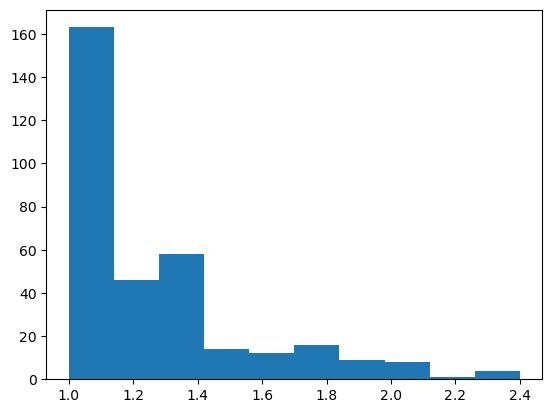

In [649]:
# salaries = google_jobs_df_cleaned[(google_jobs_df_cleaned['Salary Ratio'] != '*no salary found*') & (google_jobs_df_cleaned['Salary Range'] != '*salary ambiguous*')]['Salary Ratio'].to_list()
# salaries = list(filter(lambda x: x <= 2.5, salaries))

# plt.hist(salaries)

salaries = google_jobs_df_cleaned_test[(google_jobs_df_cleaned_test['Salary Ratio'] != '*no salary found*') & (google_jobs_df_cleaned_test['Salary Range'] != '*salary ambiguous*')]['Salary Ratio'].to_list()
salaries = list(filter(lambda x: x <= 2.5, salaries))

plt.hist(salaries)

In [650]:
# google_jobs_df_cleaned[google_jobs_df_cleaned['Salary Range'] == '*salary ambiguous*']

google_jobs_df_cleaned_test[google_jobs_df_cleaned_test['Salary Range'] == '*salary ambiguous*']

,Role,Company,Location,Posted,Source,Full / Part Time,Scraped Salary,Job Highlights,Job Description,Any Other Text,Salary From Text,Salary Lower Bound,Salary Upper Bound,Salary Range,Salary Ratio
19,Travel ER (Emergency Room) RN (Registered Nurs...,Medical Solutions,"New York, NY",15 hours ago,via Nurse.com,Full-time and Per diem,*missing data*,Benefits•$2524.84-$2796.32 wk (includes wage o...,$2524.84-$2796.32 wk (includes wage of ~$21.91...,NaN,"[2524.8, 2796.3, 21.9, 29.4, 788.8, 1060.3, 17...",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*
50,RN Labor and Delivery,Vastek Inc.,"New York, NY",23 hours ago,via Indeed,Contractor and Temp work,*missing data*,Qualifications•Labor & delivery: 2 years (Requ...,Job description\n\nRN - Labor & Delivery...\nL...,NaN,"[3200.0, 2300.0, 900.0]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*
107,ONLINE CUSTOMER SERVICE ASSISTANT,Daily Innovaties,Anywhere,24 hours ago,via ZipRecruiter,Full-time and Part-time,*missing data*,Qualifications•You care about what you are doi...,DESCRIPTION\n• Actively seeking skilled candid...,NaN,"[75.0, 150.0, 300.0, 750.0]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*
143,Travel ER (Emergency Room) RN (Registered Nurs...,Medical Solutions,"New York, NY",5 hours ago,,,*missing data*,"Responsibilities•They'll help facilitate, plan...",$2513.49-$2783.75 wk (includes wage of $17.25-...,NaN,"[2513.5, 2783.8, 17.2, 621.0, 1892.5, 600.0, 5...",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*
150,DevSecOps Engineer,Madhive,"New York, NY",23 hours ago,via ZipRecruiter,Full-time,*missing data*,Qualifications•Bachelor's degree in Computer S...,Madhive is the leading tech company engineered...,NaN,"[175000.0, 240000.0, 10000.0]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*
167,Media Strategy Director,Accenture,"New York, NY",15 hours ago,via LinkedIn,Full-time,*missing data*,Qualifications•Minimum 5 years of experience i...,We are:\n\nAccenture Song accelerates growth a...,NaN,"[86500.0, 179700.0, 93400.0, 224600.0, 194100....",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*
195,"Travel Nurse RN - Psych - $2,839 per week in N...",TravelNurseSource,"New York, NY",23 hours ago,via LinkedIn,Temp work and Per diem,*missing data*,"Responsibilities•They’ll help facilitate, plan...","Pay Rate $2,839 per week $2563.57-$2839.23 wk ...",NaN,"[2839.0, 2563.6, 2839.2, 23.0, 30.6, 827.6, 11...",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*
316,Travel RN,Staffmax Staffing and Recruiting,"New York, NY",22 hours ago,via Trabajo.org,Full-time and Contractor,*missing data*,Qualifications•PICU / Peds Step down/ NICU / N...,Are you looking for a *Pediatric Travel RN* po...,NaN,"[2520.0, 1099.0, 70.0, 39.5, 115.0]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*
337,Sr. Market Intelligence Analyst,Dassault Systèmes,"New York, NY",22 hours ago,via Indeed,Full-time,*missing data*,Qualifications•3 or more years of experience i...,Medidata: Powering Smarter Treatments and Heal...,NaN,"[96000.0, 128000.0, 101250.0, 135000.0, 84375....",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*
338,"Registered Nurse, ICU",Texas Nursing Services,"New York, NY",21 hours ago,via Trabajo.org,Full-time,*missing data*,Qualifications•Must be a graduate from an accr...,Job Summary and Qualifications\nIn collaborati...,NaN,"[28.4k, 35.5k, 42.6k, 2.0k, 5.0k, 2500.0k, 150...",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*


In [654]:
# testing out function that allows for manual corrections of any salaries that need to be changed

update_salary(google_jobs_df_cleaned_test, 2524.84, 2796.32, 19)

google_jobs_df_cleaned_test[18:20]

,Role,Company,Location,Posted,Source,Full / Part Time,Scraped Salary,Job Highlights,Job Description,Any Other Text,Salary From Text,Salary Lower Bound,Salary Upper Bound,Salary Range,Salary Ratio
18,Grant Accountant,Beacon Hill Staffing Group,"New York, NY",5 hours ago,via Indeed,Full-time,*missing data*,Qualifications•3+ years of nonprofit Accountin...,Requirements:\n• Accounting degree\n• 3+ years...,NaN,[],*no salary found*,*no salary found*,*no salary found*,*no salary found*
19,Travel ER (Emergency Room) RN (Registered Nurs...,Medical Solutions,"New York, NY",15 hours ago,via Nurse.com,Full-time and Per diem,*missing data*,Benefits•$2524.84-$2796.32 wk (includes wage o...,$2524.84-$2796.32 wk (includes wage of ~$21.91...,NaN,"[2524.8, 2796.3, 21.9, 29.4, 788.8, 1060.3, 17...",2524.84,2796.32,"$2,524.84-$2,796.32",1.1


In [ ]:
# outstanding issues:

# index 120: '$50 billion' gets counted as a $50 salary when it's really talking about the industry/ company
    # check if item in list after the number is in a list of words like Bil, M, billion etc
# index 36: $130,000.00 - 150,000.00 will not pull second value

# index 30: salary in title, not being found
# index 100: when user adds K to the end of an unabbreviated number... maybe not worth trying to fix cause pretty rare error
# index 139: user error entry, adding extra 0 to one entry... not really worth automating this away, maybe just have 
    # to find outliers and manually correct or drop once data is collected
# consider sitation where bonus is listed along with single salary number... would be inaccurate
# there are false positive cases like when just a bonus is included

## ^ for these issues, maybe just look at entries with really weird ratios or "salary ambiguous" tags and manually fix them

# fixed issues:

# index 114: when lower bound is higher than upper bound -> fixed by sorting the list
# lists that are more than 2 items long (for both functions) -> right now, addressed by saying "salary ambiguous"
# index 118: 
    # $80,000-$90,000/ year plus commissions and incentives in the range of $20,000-$30,000/ year
    # Ouput: 8000090000.0 - 2000030000.0
    # right now, addressed by saying "salary ambiguous"
# index 65: [1,800, $118,000—$210,000] leads to 1800.0 and 118000210000.0 
    # weirdly there are two kinds of '—' it seems despite them looking indentical, so just added the extra one in
# index 3 and others: sorts alphabetically, not numerically 
    # sorted(scraped_df['Salary From Description'][3])[0]
# index 120: $50MM+ gets counted as a salary when it's really talking about the industry/ company
    # remove all numbers that contain m or b
# index 1, 11: cases where salary range (or just single salary) is repeated twice labeled as ambiguous
    # remove duplicates from lists (round all of them to avoid decimal issues)
    # this could help if scanning Job Highlights and Descriptions in one go as well
# index ?: if $130,000.00- $150,000.00 or $130,000.00 -$150,000.00 will be deemed ambiguous
    # use method saved below to break numbers up, and if the result is still just two numbers, use them, if not, deem ambiguous

## Old Code

In [ ]:
# # url filters: jobs posted within past day, within 15 miles of New York, NY
# google_jobs_url = 'https://www.google.com/search?q=jobs&oq=google+jobs+data+analyst&aqs=chrome..69i57j69i59j0i512j0i22i30i625l4j69i60.4543j0j7&sourceid=chrome&ie=UTF-8&ibp=htl;jobs&sa=X&ved=2ahUKEwjXsv-_iZP9AhVPRmwGHX5xDEsQutcGKAF6BAgPEAU&sxsrf=AJOqlzWGHNISzgpAUCZBmQA1mWXXt3I7gA:1676311105893#fpstate=tldetail&htivrt=jobs&htichips=city:Owg_06VPwoli_nfhBo8LyA%3D%3D,date_posted:today&htischips=city;Owg_06VPwoli_nfhBo8LyA%3D%3D:New%20York_comma_%20NY,date_posted;today&htilrad=24.1401&htidocid=9dwQD_uVzp1Nu-9BAAAAAA%3D%3D'
# # path to CSV where google jobs dataset will be held
# google_jobs_df_path = '/Users/ravram/Desktop/pay-transparency/data/output/google-jobs-cronjob.csv' # need to change path when put on server
# # path to CSV where extra column data will be held
# extra_columns_df_path = '/Users/ravram/Desktop/pay-transparency/data/output/google-jobs-extra-cols-cronjob.csv' # need to change path when put on server

# def scrape_google_jobs(url, final_path_location, postings):
    
# # url: web url to the google jobs page that will be scraped (str)
# # final_path_location: path to the CSV file where the scraped data will be stored (str)
# # postings: number of job postings to be scraped -> can be increased by increments of 10 starting at 20, going up to limit of 150 (int)
    
#     options = Options() # preparing to run in headless browser
#     options.add_argument('headless') 

#     # using sing selenium to launch and scroll through the Google Jobs page
#     url = url
#     driver = webdriver.Chrome(options=options)
    
#     user_agent = driver.execute_script("return navigator.userAgent;")
#     user_agent = user_agent.replace("HeadlessChrome","Chrome")
#     driver.execute_cdp_cmd('Network.setUserAgentOverride',{"userAgent": f'{user_agent}'})
    
#     driver.get(url)

#     # column names and paths to desired data
#     xpaths = { 
#      'Role'            :"./div/div[1]/div/div[1]/h2",
#      'Company'         :"./div/div[1]/div/div[2]/div[2]/div[1]",
#      'Location'        :"./div/div[1]/div/div[2]/div[2]/div[2]",
#      'Posted'          :"./div/div[3]/div[1]/span[2]/span",
#      'Scraped Salary'  :".//span[@class='LL4CDc' and contains(@aria-label,'Salary')]/span",
#      'Job Highlights'  :"./div/div[4]/div[1]/div[2]/g-expandable-container/div/g-expandable-content[2]/span",
#      'Job Description' :"./div/div[5]/div/span",
#      'Any Other Text'  :"./div/div[4]" 
#     }
    
#     scrolls_to_do = postings # setting number of job postings to be scraped
#     scrolls_done = 0
#     data = {key:[] for key in xpaths} # data will be added to this dict
    
#     # stay in while loop until desired number of postings have been scrolled to
#     while scrolls_done < scrolls_to_do: 
#         lis_scr = driver.find_elements(By.XPATH, "//li[@data-ved]//div[@role='treeitem']/div/div") # path to section of page where user can scroll through job postings 
#         #print('lis length=',len(lis_scr), f'{scrolls_done=}', end='\r')
        
#         if (len(lis_scr) == scrolls_done) and (scrolls_to_do - scrolls_done) > 0: # in case the postings variable exceeds number of available job posting entries (otherwise code will be stuck in infinite loop)
        
#             print('\nNote: requested # of postings greater than available postings')
#             scrolls_to_do = len(lis_scr) # resetting scrolls_to_do to the max length of lis_scr so can break out of while loop
            
#         # scrolling down the page to make desired number of job postings load, therefore making them accessible for scraping
#         for li_scr in lis_scr[scrolls_done:]:
#             driver.execute_script('arguments[0].scrollIntoView({block: "center", behavior: "smooth"});', li_scr) 

#             scrolls_done += 1
#             print(f'{scrolls_done=}', end='\r') # to visualize how many scrolls have been performed
#             time.sleep(.2)     
    
#     lis_descr = driver.find_elements(By.XPATH, "//*[@id='gws-plugins-horizon-jobs__job_details_page']") # path to description page for each job
    
#     print('')
#     jobs_done = 0 
    
#     for li_descr in lis_descr[0:scrolls_to_do]: # looping through desired number of job description pages, which is where the data will be pulled from
    
#         for key in xpaths:

#             try: # pull data at each path in the xpaths dict for each job posting
#                 t = li_descr.find_element(By.XPATH, xpaths[key]).get_attribute('innerText')
#             except NoSuchElementException: # if can't find, indicate with text
#                 t = '*missing data*'
#             if t == '': # in cases where element exists but is just ''
#                 t='*missing data*'
                
#             data[key].append(t) # add to data dict
            
#         jobs_done += 1
#         print(f'{jobs_done=}', end='\r') # to visualize how many jobs have been completed
#         time.sleep(.2)

#     scraped_df = pd.DataFrame(data) # convert to df
    
#     for ind in scraped_df.index: # Any Other Text collects full text for posting... only worth keeping if Job Highlights and Description are empty, otherwise redundant info just taking up space
        
#         if (scraped_df['Job Highlights'][ind] != '*missing data*') and (scraped_df['Job Description'][ind] != '*missing data*'):
            
#             scraped_df.loc[ind, 'Any Other Text'] = np.nan # erasing this text if either Job Highlights or Description is present
    
#     path = final_path_location 
    
#     if os.path.exists(path): # if CSV already exists at the specified path, add the new data found in scraped_df 
#         original_df = pd.read_csv(path) # convert existing CSV to df
#         original_df = pd.concat([original_df,scraped_df]) # add new data
#         original_df = original_df.drop_duplicates(subset=['Role','Company','Location','Scraped Salary','Job Highlights','Job Description', 'Any Other Text']) # drop entries with identical data in these columns... leaving Posted out of this in case duplicates are posted at dif times
#         original_df.to_csv(path, index = False) # redownloading updated df to the specified path
#     else: # otherwise, create new file at this path (for first time function is run)
#         scraped_df.to_csv(path, index = False)
    
#     return 

# scrape_google_jobs(google_jobs_url, google_jobs_df_path, 150)

In [ ]:
# def find_salaries(df, col_name):
    
#     salary_from_col = 'Salary From ' + col_name
    
#     df[salary_from_col] = '' # creating column where salaries found in description will be placed
#     df['Salary Lower Bound'] = '' # lower bound
#     df['Salary Upper Bound'] = '' # upper bound
    
#     for ind in df.index: # iterating through the descriptions for each job

#         salary_list = []

#         phrase = df[col_name][ind] # text in description
#         phrase = phrase.replace('•',' ') # eliminating bullet points
#         phrase_to_list = phrase.split(" ") # creating list of all strings in the description

#         for i in range(len(phrase_to_list)): # iterating through phrase_to_list

#             if len(phrase_to_list[i]) > 0: # otherwise -1 index will break code
                
#                 if phrase_to_list[i] not in ['401K', '401k']: # eliminating '401K' so doesn't get labeled as salary
                    
#                     if not [True if e in phrase_to_list[i].lower() else False for e in ['b','m']][0]: # weeding out cases like '$10b industry' or '$3M company'
                    
#                         if ('$' in phrase_to_list[i]) or ('k' == phrase_to_list[i][-1].lower() and phrase_to_list[i][-2].isdigit()): # looking for salary indicators

#                             salary_list.append(phrase_to_list[i]) # adding strings with salary indicators to ongoing list

#                         if phrase_to_list[i] == '$' and phrase_to_list[i+1][0].isdigit(): # if there's a space between $ and number

#                             salary_list.append(phrase_to_list[i+1]) # add the subsequent list item in this case

#                         df[salary_from_col][ind] = salary_list # place in this new column
          
#         # now that salaries are collected from the description, creating lower and upper bounds based on given info
                
#         if df['Scraped Salary'][ind] == '*missing data*': # if salary not initially scraped
            
#             if df['Salary From ' + col_name][ind] == []: # if no salary found in description
        
#                 df['Salary Lower Bound'][ind] = '*no salary found*'
#                 df['Salary Upper Bound'][ind] = '*no salary found*'
            
#             else: # if salary is found in the description
                
#                 # if first value is just $, remove so doesn't affect making the range (cases where there's originally a space between $ and number)
                
#                 for i in df[salary_from_col][ind]:
#                     if i == '$':
#                         df[salary_from_col][ind].remove('$') 
                        
#                 desc_sal_list = [] # in cases where there are two "numbers" that are really 1-2 ranges -> [20K-30K,5K-6K] or [20K,15K-16K]
                    
#                 for i in range(len(df[salary_from_col][ind])): # removing the dashes and isolating all of the individual numbers

#                     if '–' in df[salary_from_col][ind][i]: 
#                         desc_sal = df[salary_from_col][ind][i].replace('–', ' ')
#                     if '—' in df[salary_from_col][ind][i]: 
#                         desc_sal = df[salary_from_col][ind][i].replace('—', ' ')
#                     elif '-' in df[salary_from_col][ind][i]:
#                         desc_sal = df[salary_from_col][ind][i].replace('-', ' ')
#                     else:
#                         desc_sal = df[salary_from_col][ind][i]

#                     desc_sal_list = desc_sal_list + desc_sal.split(' ')

#                     if '' in desc_sal_list: desc_sal_list.remove('')
                        
#                 df[salary_from_col][ind] = desc_sal_list
                
#                 # attempting to preemptively correct cases that would otherwise trigger 'salary ambiguous' label so that they can be properly processed
                
#                 if len(df[salary_from_col][ind]) > 2: # when length of list > 2, will be marked ambiguous unless corrected first
                    
#                     df[salary_from_col][ind] = clean_salary_ambiguous(df[salary_from_col][ind]) 
                            
#                 # now that all the lists are cleaned, proceed to determine salary ranges:
                
#                 if len(df[salary_from_col][ind]) > 2: # if multiple numbers are still found after cleaning, hard to tell what salary range is, will be marked ambiguous
                    
#                     df['Salary Lower Bound'][ind] = '*salary ambiguous*'
#                     df['Salary Upper Bound'][ind] = '*salary ambiguous*'
                
#                 if len(df[salary_from_col][ind]) == 2: # if two entries provided, create salary range
                    
#                     df['Salary Lower Bound'][ind] = df[salary_from_col][ind][0] 
#                     df['Salary Upper Bound'][ind] = df[salary_from_col][ind][1]
                
#                 elif len(df[salary_from_col][ind]) == 1: # one entry
                                          
#                     df['Salary Lower Bound'][ind] = df[salary_from_col][ind][0] 
                          
#         else: # if salary found in initial scrape, use it as final salary 
            
#             if '–' in df['Scraped Salary'][ind]: # removing dashes
#                 scraped_sal = df['Scraped Salary'][ind].replace('–', ' ')
#             elif '—' in df['Scraped Salary'][ind]: # removing dashes
#                 scraped_sal = df['Scraped Salary'][ind].replace('—', ' ')
#             elif '-' in df['Scraped Salary'][ind]: # removing dashes
#                 scraped_sal = df['Scraped Salary'][ind].replace('-', ' ')
#             else:
#                 scraped_sal = df['Scraped Salary'][ind]
                
#             scraped_sal_list = scraped_sal.split(' ') # seperating into list of strings
            
#             df['Salary Lower Bound'][ind] = scraped_sal_list[0] # first number
#             df['Salary Upper Bound'][ind] = scraped_sal_list[1] # second number

#     return df

In [ ]:
# def scrape_extra_columns(url, final_path_location, postings):
    
# # url: web url to the google jobs page that will be scraped (str)
# # final_path_location: path to the CSV file where the scraped data will be stored (str)
# # postings: number of job postings to be scraped -> can be increased by increments of 10 starting at 20, going up to limit of 150 (int)
    
#     options = Options() # preparing to run in headless browser
#     options.add_argument('headless')

#     # using sing selenium to launch and scroll through the Google Jobs page
#     url = url
#     driver = webdriver.Chrome(options=options)
    
#     user_agent = driver.execute_script("return navigator.userAgent;")
#     user_agent = user_agent.replace("HeadlessChrome","Chrome")
#     driver.execute_cdp_cmd('Network.setUserAgentOverride',{"userAgent": f'{user_agent}'})
    
#     driver.get(url)

#     # column names and paths to desired data
#     xpaths = {
#      'Role'            :"./div[2]",
#      'Company'         :"./div[4]/div/div[1]",
#      'Source'          :"./div[4]/div/div[3]",
#      'Full / Part Time':".//*[name()='path'][contains(@d,'M20 6')]/ancestor::div[1]",
#     }
    
#     jobs_to_do = postings # setting number of job postings to be scraped
#     jobs_done = 0
#     data = {key:[] for key in xpaths} # data will be added to this dict

#     # stay in while loop until desired number of postings have been scrolled to and scraped 
#     while jobs_done < jobs_to_do: 
#         lis = driver.find_elements(By.XPATH, "//li[@data-ved]//div[@role='treeitem']/div/div") # path to section of page where user can scroll through job postings 
#         # print('lis length=',len(lis), f'{jobs_done=}', end='\r')
        
#         if (len(lis) == jobs_done) and (jobs_to_do - jobs_done) > 0: # in case the postings variable exceeds number of available job posting entries (otherwise code will be stuck in infinite loop)
        
#             print('\nNote: requested # of postings greater than available postings')
#             jobs_to_do = len(lis) # resetting scrolls_to_do to the max length of lis_scr so can break out of while loop
        
#         # scrolling down the page to make desired number of job postings load, therefore making them accessible for scraping
#         for li in lis[jobs_done:]:
#             driver.execute_script('arguments[0].scrollIntoView({block: "center", behavior: "smooth"});', li)

#             for key in xpaths:
#                 try: # pull data at each path in the xpaths dict for each job posting
#                     t = li.find_element(By.XPATH, xpaths[key]).get_attribute('innerText')
#                 except NoSuchElementException: # if can't find, indicate with text
#                     t = '*missing data*'
#                 data[key].append(t) # add to data dict

#             jobs_done += 1
#             print(f'{jobs_done=}', end='\r') # to visualize how many jobs have been completed
#             time.sleep(.2)
            
#     cols_to_add = pd.DataFrame(data) # convert to df
        
#     path = final_path_location 
    
#     if os.path.exists(path): # if CSV already exists at the specified path, add the new data found in scraped_df 
#         original_df = pd.read_csv(path) # convert existing CSV to df
#         original_df = pd.concat([original_df,cols_to_add]) # add new data
#         original_df = original_df.drop_duplicates() # drop entries with identical data 
#         original_df.to_csv(path, index = False) # redownloading updated df to the specified path
#     else: # otherwise, create new file at this path (for first time function is run)
#         cols_to_add.to_csv(path, index = False)    
        
#     return 

# scrape_extra_columns(google_jobs_url, extra_columns_df_path, 150) 

In [443]:
# # og method
# #def scrape_google_jobs(google_jobs_df):

# #using selenium to launch and scroll through the Google Jobs page
# url = "https://www.google.com/search?q=in+new+york+city&oq=google+jobs+data+analyst&aqs=chrome..69i57j69i59j0i512j0i22i30i625l4j69i60.4543j0j7&sourceid=chrome&ie=UTF-8&ibp=htl;jobs&sa=X&ved=2ahUKEwjXsv-_iZP9AhVPRmwGHX5xDEsQutcGKAF6BAgPEAU&sxsrf=AJOqlzWGHNISzgpAUCZBmQA1mWXXt3I7gA:1676311105893#fpstate=tldetail&htivrt=jobs&htidocid=DKwJ4ogc_UrLs-QfAAAAAA%3D%3D"
# driver = webdriver.Chrome()
# driver.get(url)

# xpaths = {
#  #'Logo'            :"./div[1]//img",
#  'Role'            :"./div[2]",
#  'Company'         :"./div[4]/div/div[1]",
#  'Location'        :"./div[4]/div/div[2]",
#  'Source'          :"./div[4]/div/div[3]",
#  'Posted'          :".//*[name()='path'][contains(@d,'M11.99')]/ancestor::div[1]",
#  'Full / Part Time':".//*[name()='path'][contains(@d,'M20 6')]/ancestor::div[1]",
#  'Salary'          :".//span[@class='LL4CDc' and contains(@aria-label,'Salary')]/span"
# }

# jobs_to_do = 160
# jobs_done = 0
# data = {key:[] for key in xpaths}

# while jobs_done < jobs_to_do:
#     lis = driver.find_elements(By.XPATH, "//li[@data-ved]//div[@role='treeitem']/div/div")
#     print('lis length=',len(lis), f'{jobs_done=}', end='\r')
    
#     if (len(lis) == jobs_done) and (jobs_to_do - jobs_done) > 0:
        
#         print('\noops')
#         jobs_to_do = len(lis)

#     for li in lis[jobs_done:]:
#         driver.execute_script('arguments[0].scrollIntoView({block: "center", behavior: "smooth"});', li)

#         for key in xpaths:
#             try:
#                 t = li.find_element(By.XPATH, xpaths[key]).get_attribute('src' if key=='Logo' else 'innerText')
#             except NoSuchElementException:
#                 t = '*missing data*'
#             data[key].append(t)

#         jobs_done += 1
#         #print(f'{jobs_done=}', end='\r')
#         time.sleep(.2)

#         scraped_df = pd.DataFrame(data)

# # google_jobs_df = google_jobs_df.append(scraped_df)
# # # google_jobs_df = google_jobs_df.drop_duplicates()

# #     #return google_jobs_df
    
# # scraped_df

In [275]:
# import requests
# from serpapi import GoogleSearch
# import json

# finding location params for NYC

# response = requests.get('https://serpapi.com/locations.json?q=New York&limit=5')
# response_list = response.json()

# response_list

In [ ]:
# from serpapi import GoogleSearch

# serpapi_key = 'd5ff8cd8814fc2d40478abe398700948378acf0cedd38fa0ceb5c8b1a0bb295a'

# params = {
#     'api_key': serpapi_key,                                     # https://serpapi.com/manage-api-key
#     'chips': 'date_posted:week,city:Owg_06VPwoli_nfhBo8LyA==',  # city = NYC, date_posted:week for all data posted in last week
#     'q': 'new york',                                            # search query
#     'hl': 'en',                                                 # language of the search
#     'engine': 'google_jobs',                                    # SerpApi search engine
#     'start': 0                                                  # pagination
# }

# google_jobs_results = []

# while True:
#     search = GoogleSearch(params) # where data extraction happens on the SerpApi backend
#     result_dict = search.get_dict() # JSON -> Python dict

#     if 'error' in result_dict:
#         break
    
#     for result in result_dict['jobs_results']:
#         google_jobs_results.append(result)

#     # increments 'start' parameter to 10 which will trigger Google Jobs to paginate to the next page
#     params['start'] += 10

# #print(json.dumps(google_jobs_results, indent=2, ensure_ascii=False))

In [ ]:
# google_jobs_df = pd.DataFrame(google_jobs_results)
# google_jobs_df

In [ ]:
# print(json.dumps(google_jobs_results, indent=2, ensure_ascii=False))